In [1]:
%%capture
import struct 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from helpers import read_echogram


In [2]:
class EchoGram:
    def __init__(self, filename, channels=None, depthline=False):
        self.filename = filename
        self.data, self.echo = self.test_overlay_wb_echo(filename, channels, depthline)
        
    def test_overlay_wb_echo(self, filename, channels=None, depthline=False):
        # Load sounding data and echogram.
        data, echo = read_echogram(filename, channels)

        ## Calculate sampling rate, using assumption that y-axis is in depth (ft)
        ## - not actually used in this function but given here as an illustration.
        # time1 = np.array([i["time1"] for i in data])
        # dz = time1[1:] - time1[:-1]
        if depthline:
            ## Calculate the water depth in y-axis samples
            wb = np.array([i["water_depth"] for i in data])
            lower_limit = np.array([i["lower_limit"] for i in data])
            wb_s =  wb * echo.shape[0] / lower_limit

        fig, axes = plt.subplots()
        axes.imshow(echo, aspect='auto')
        if depthline:
            axes.plot([i["frame_index"] for i in data],
                        wb_s, linewidth=2, color="red")
        fig.show()
        #fig.savefig('sss.png', dpi=fig.dpi)
        return data, echo

### Datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

### Channel (sonar sensor type)
- 0 = Primary (Traditional Sonar)
- 1 = Secondary (Traditional Sonar)
- 2 = DSI (Downscan Imaging)
- 3 = Sidescan Left
- 4 = Sidescan Right
- 5 = Sidescan (Composite)
Another other value is treated as Invalid.

## File:Sonar_2021-10-16_12.53.38 Speed=4mph

  0%|          | 0.00/415M [00:00<?, ?B/s]

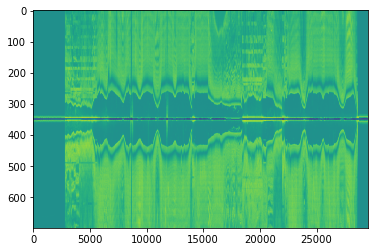

In [3]:
echogram1 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[5])

In [4]:
print(echogram1.data[0].keys())
print(echogram1.data[0])

dict_keys(['offset', 'previous_primary_offset', 'previous_secondary_offset', 'previous_downscan_offset', 'previous_left_sidescan_offset', 'previous_right_sidescan_offset', 'previous_composite_sidescan_offset', 'framesize', 'previous_framesize', 'channel', 'packetsize', 'frame_index', 'upper_limit', 'lower_limit', 'frequency', 'water_depth', 'keel_depth', 'gps_speed', 'temperature', 'lon_enc', 'lat_enc', 'water_speed', 'course', 'altitude', 'heading', 'flags', 'time1', 'has_altitude', 'has_heading', 'has_track', 'has_water_speed', 'has_position', 'has_packet', 'has_temperature', 'has_gps_speed', 'gps_speed_kph', 'longitude', 'latitude', 'water_depth_m', 'headersize', 'heading_deg'])
{'offset': 8, 'previous_primary_offset': 0, 'previous_secondary_offset': 0, 'previous_downscan_offset': 0, 'previous_left_sidescan_offset': 0, 'previous_right_sidescan_offset': 0, 'previous_composite_sidescan_offset': 8, 'framesize': 2944, 'previous_framesize': 0, 'channel': 5, 'packetsize': 2800, 'frame_ind

In [5]:
print("echo shape:",echogram1.echo.shape)
print("type(data):",type(echogram1.data))
print("length:",len(echogram1.data))

echo shape: (700, 29551)
type(data): <class 'list'>
length: 29551


data is a list of dictionaries
echo is an nd array (2D=only rows and columns)

In [12]:
rows, cols = echogram1.echo.shape
print("min=",min(echogram1.echo.flat))
print("max=",max(echogram1.echo.flat))
vmin=min(echogram1.echo.flat)
vmax=max(echogram1.echo.flat)

min= -2143262300.0
max= 2141233300.0


## Half segment of sonar file with "hot" colors

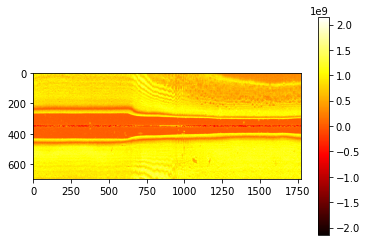

In [14]:
plt.imshow(echogram1.echo[:,int(cols/2):int(cols*2.8/5)], cmap='hot', vmin=vmin, vmax=vmax)
plt.colorbar()

## Last tenth of the sonar file with "veridis" colors

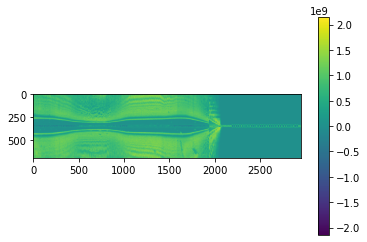

In [7]:
plt.imshow(echogram1.echo[:,int(cols*9/10):-1],)
plt.colorbar()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

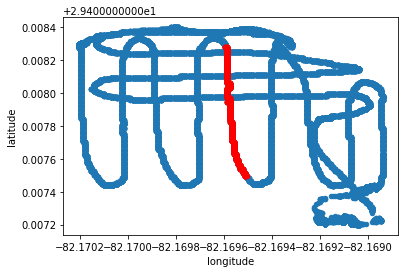

In [39]:
df = pd.DataFrame(echogram1.data)
fig = plt.figure()
ax1 = df.plot.scatter(x="longitude", y="latitude")
df.loc[9600:10800,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax1)


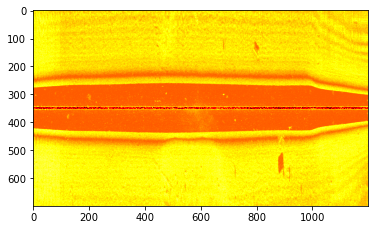

In [15]:
plt.imshow(echogram1.echo[:,9600:10800], cmap='hot', vmin=vmin, vmax=vmax)

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

  0%|          | 0.00/327M [00:00<?, ?B/s]

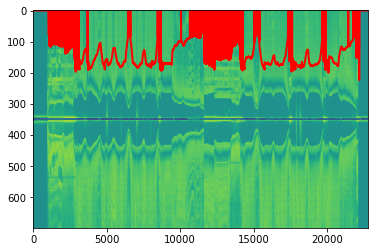

In [4]:
echogram6mph = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])

length: 22784


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

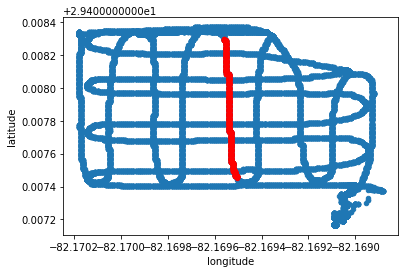

In [5]:
print("length:",len(echogram6mph.data))
df2 = pd.DataFrame(echogram6mph.data)
fig = plt.figure()
ax2 = df2.plot.scatter(x="longitude", y="latitude")
df2.loc[5600:6400,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2)

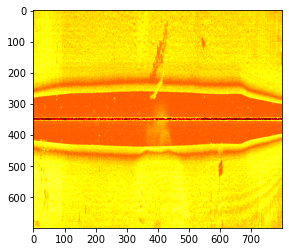

In [34]:
plt.imshow(echogram6mph.echo[:,5600:6400], cmap='hot')

## File:Sonar_2021-10-16_14.38.24 Speed=7mph

  0%|          | 0.00/141M [00:00<?, ?B/s]

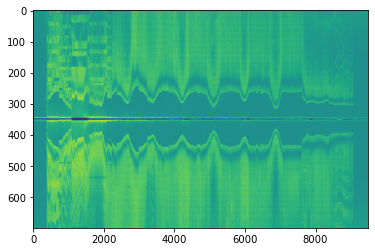

In [17]:
echogram7mph = EchoGram('./log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2', channels=[5])

length: 9491


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

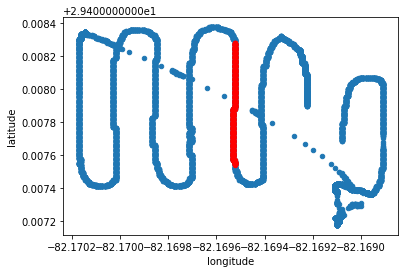

In [81]:
print("length:",len(echogram7mph.data))
df3 = pd.DataFrame(echogram7mph.data)
fig = plt.figure()
ax3 = df3.plot.scatter(x="longitude", y="latitude")
df3.loc[4400:5000,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax3)

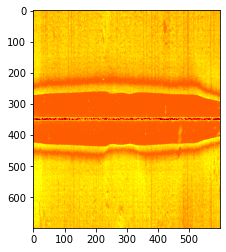

In [20]:
vmin=min(echogram7mph.echo.flat)
vmax=max(echogram7mph.echo.flat)
plt.imshow(echogram7mph.echo[:,4400:5000], cmap='hot', vmin=vmin, vmax=vmax)

  0%|          | 0.00/96.4M [00:00<?, ?B/s]

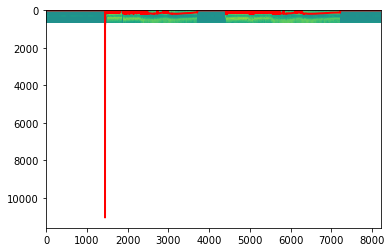

In [84]:
echogram4 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2', channels=[5])

length: 8217


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

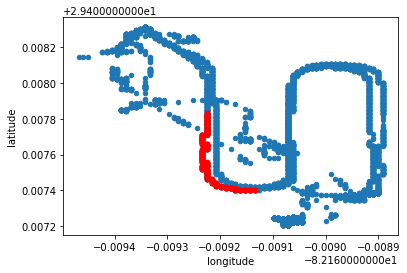

In [ ]:
print("length:",len(echogram4.data))
df4 = pd.DataFrame(echogram4.data)
fig = plt.figure()
ax4 = df4.plot.scatter(x="longitude", y="latitude")
df4.loc[6200:6600,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax4)

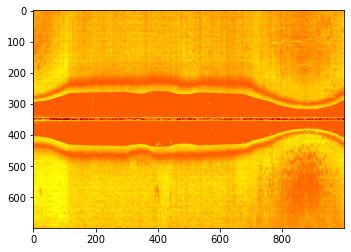

In [ ]:
plt.imshow(echogram4.echo[:,6000:7000], cmap='hot')

# DownScan Sonar

  0%|          | 0.00/415M [00:00<?, ?B/s]

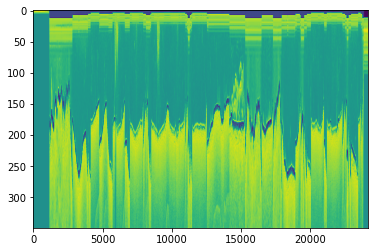

In [5]:
downscan = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[2], depthline=False)

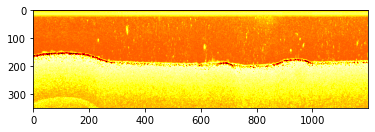

In [6]:
plt.imshow(downscan.echo[:,9600:10800], cmap='hot')

## North-South and East-West comparisson

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

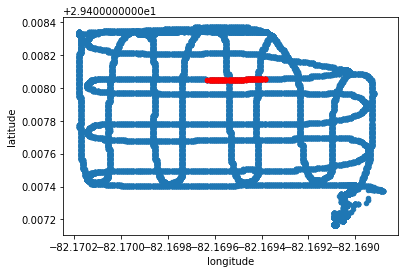

In [6]:
fig = plt.figure()
ax2 = df2.plot.scatter(x="longitude", y="latitude")
df2.loc[15600:15800,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2) 

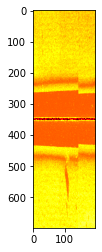

In [7]:
plt.imshow(echogram6mph.echo[:,15600:15800], cmap='hot')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

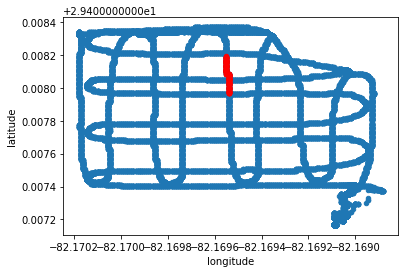

In [42]:
fig = plt.figure()
ax2 = df2.plot.scatter(x="longitude", y="latitude")
df2.loc[6100:6300,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2) 
# both combined - np.r_[6100:6300,15600:15800]

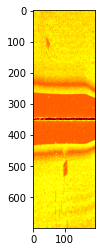

In [43]:
plt.imshow(echogram6mph.echo[:,6100:6300], cmap='hot')

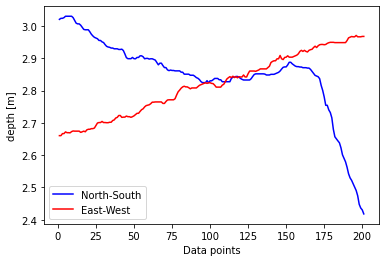

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
one = df2.loc[6100:6300,:]['water_depth_m']
two = df2.loc[15600:15800,:]['water_depth_m']
ax.plot(range(1,202),one,'b', label='North-South')
ax.plot(range(1,202), two, 'r', label='East-West')
ax.set_ylabel('depth [m]')
ax.set_xlabel('Data points')
ax.legend()
plt.show()

## Side Scan Sonar Image of a curve

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

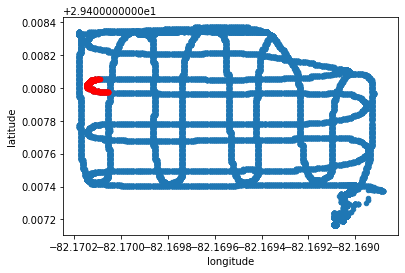

In [25]:
fig = plt.figure()
ax2 = df2.plot.scatter(x="longitude", y="latitude")
df2.loc[16200:16500,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2) #15600:15800

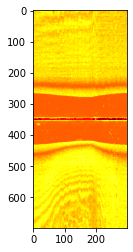

In [26]:
plt.imshow(echogram6mph.echo[:,16200:16500], cmap='hot')